# Modeling Dengue
This is an assignment for INFO 370 Core Method in Data Science (Autumn 2018) at University of Washington. The task for this project is to measure the **strength of association** between different environmental variables and the number of cases of Dengue. This Jupyter Notebook is a **polished report** of our analysis on Dengue (source of dataset: [link](https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread)).


## Problem Overview
   Dengue fever is the leading cause of illness and death in the tropics and subtropics, regions which contain a little more than one-third of the world population. Mild cases of Dengue fever can cause high fever, rash and muscle, and joint pain, while more severe cases can lead to severe bleeding, a sudden drop in blood pressure and death. Dengue is transmitted to people by mosquitoes, and because of this relationship, the disease’s spread spikes yearly when rainfall is optimal for mosquitoe breeding. In fact, this relationship between the disease and the mosquito breeding period is so entwined that, every breeding season Dengue is classified as an epidemic within the tropics and sub-tropics. This relationship between the disease and mosquitoes also means that environmental factors that promote mosquito life will also work as indicators for the spread of Dengue. Limiting exposure to mosquitos in at-risk areas is the only known prevention method for the disease, as a vaccine has yet to be developed. This coupled with the fact that the disease is rapidly spreading, increasing from having cases in 9 countries in 1970 to over 100 countries by 2015, makes it a high priority for many world health organizations. In order to perform our predictions, we were given access to data from a variety of U.S. Federal Government agencies. 
   
   Citations:
   1. Centers for Disease Control and Prevention. (n.d.). Retrieved from [link](https://www.cdc.gov/).
   2. Here's the ideal temp for mosquito-borne diseases. (2017, May 05). Retrieved from [link](https://www.futurity.org/climate-change-mosquito-diseases-1420452/).
   3. http://www.who.int/denguecontrol/epidemiology/en/
   

### Pertinent Variables 
Because dengue is carried by mosquitoes, it’s transmission dynamics are related to climate variables such as temperature and precipitation. To predict the number of dengue fever cases (the `total_cases` label for each `(city, year, weekofyear)` ) based on the provided datasets, it’s important to look at these following information ([source](https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/page/82/#features_list)):

#### City and Date Indicators
- There are data for _two cities_, San Juan (`sj`) and Iquitos (`iq`) in the `city` column. 
- The date indicator is provided on a `(year, weekofyear, week_start_date)` timescale, which is given in yyyy-mm-dd format.

#### NOAA's GHCN daily climate data weather station measurements
- `station_avg_temp_c` – _Average_ temperature
- `station_precip_mm` – _Total_ precipitation

#### PERSIANN satellite precipitation measurements (0.25x0.25 degree scale)
- `precipitation_amt_mm` – _Total_ precipitation

#### NOAA's NCEP Climate Forecast System Reanalysis measurements (0.5x0.5 degree scale)
- `reanalysis_sat_precip_amt_mm` – _Total_ precipitation
- `reanalysis_precip_amt_kg_per_m2` – _Total_ precipitation **(? same as ↾)**
- `reanalysis_dew_point_temp_k` – _Mean_ dew point temperature
- `reanalysis_air_temp_k` – _Mean_ air temperature
- `reanalysis_avg_temp_k` – _Average_ air temperature **(? same as ↾)**
- `reanalysis_relative_humidity_percent` – _Mean_ relative humidity
- `reanalysis_specific_humidity_g_per_kg` – _Mean_ specific humidity


As you can see, there are a few columns that represent the same data point (e.g. `precipitation`) from different sources. Are there any _substantive_ differences from the sources and why would they all be included?

## Set Up

In [52]:
%matplotlib inline
from __future__ import print_function
from __future__ import division
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.formula.api as smf


In [97]:
# load the provided data
dengue_features = pd.read_csv('data/dengue_features_train.csv', index_col=[0,1,2])
dengue_labels = pd.read_csv('data/dengue_labels_train.csv', index_col=[0,1,2])
dengue_features_no_index = pd.read_csv('data/dengue_features_train.csv')

## Data Preperation

In [98]:
#Fill all nan values with the previous value. Since this is a time series, it should work as a good estimate.
dengue_features.fillna(method='ffill', inplace=True)

# Add column that is average of all three temperature measurements
dengue_features["avg_air_temp_k"] = (dengue_features["reanalysis_air_temp_k"] + dengue_features["reanalysis_avg_temp_k"] + (dengue_features["station_avg_temp_c"] + 273.15)) / 3

#Create a merged data table for exploration
merged_data = pd.merge(dengue_features_no_index, dengue_labels, on=['city', 'weekofyear', 'year'], how='outer')

#Drop week start date
dengue_features.drop('week_start_date', axis=1, inplace=True)

# Seperate data for San Juan
sj_data = dengue_features.loc['sj']
sj_labels = dengue_labels.loc['sj']

# Separate data for Iquitos
iq_data = dengue_features.loc['iq']
iq_labels = dengue_labels.loc['iq']

# Add in total cases
sj_data['total_cases'] = sj_labels.total_cases
iq_data['total_cases'] = iq_labels.total_cases

## Exploratory Data Analysis

### Week of year vs. Total Cases
- These plots show the total cases by each week of the year for each city. In the cases of both city, the number of cases starts out moderatly high at week zero, with a slow decline and steadying out until around week 35-30. At this point the number of total cases begins to increase rapidly.

1. What is the distribution of the number of cases of Dengue each week?

> The above scatterplot shows a **moderate**, **positive**, **non-linear** association between _week of year_ and the number of _total cases_ for both _cities_.

2. How does the number of cases fluctuate over time? Do these temporal relationships persist in both locations?

> Both cities see a spike in total cases, that begins around the week 30 mark continues to increase until around week 50 and then declines from there, staying around the same number for weeks 10-20.


<Figure size 432x288 with 0 Axes>

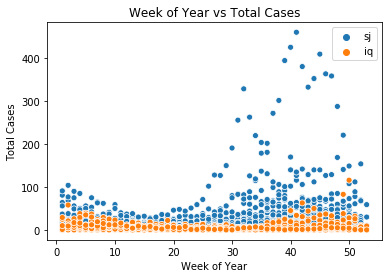

<Figure size 432x288 with 0 Axes>

In [9]:
# Scatterplot showing the distribution over times
plot = sns.scatterplot(x="weekofyear", y="total_cases", hue=merged_data.city.values, data=merged_data)
plot.set(xlabel='Week of Year', ylabel='Total Cases', title="Week of Year vs Total Cases")
plt.figure()

### Correlation between variables

In [10]:
sj_correlations = sj_data.corr()
iq_correlations = iq_data.corr()

- The highest correlation in both cities is reanalysis_specific_humidity, with reanalysis_dew_point_temp being the second highest correlated. Surprisingly, both cities reported low correlations between rain related variables and total cases, which goes against or initial intuition that more rain would lead to more mosquitioes and thus more cases of dengue. Station avg temp, reanalysis_min_air_temp, avg_air_temp?

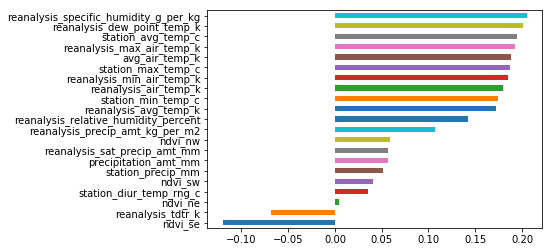

In [33]:
(sj_correlations.total_cases.drop('total_cases').sort_values(ascending=True).plot.barh())

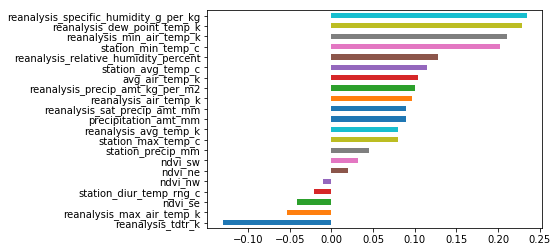

In [34]:
(iq_correlations.total_cases.drop('total_cases').sort_values(ascending=True).plot.barh())

### Specific humidity vs Total Cases
- When looking at reanalysis_specific_humidity and total cases more closely, we can see a spike in total cases around the 16-18 grams of humidity per kilogram. This spike occurs in both cities, and suggests that these humidity levels might be beneficial to mosqitoe reproduction.

<Figure size 432x288 with 0 Axes>

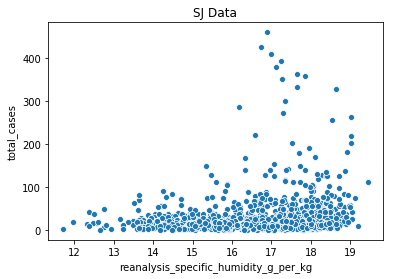

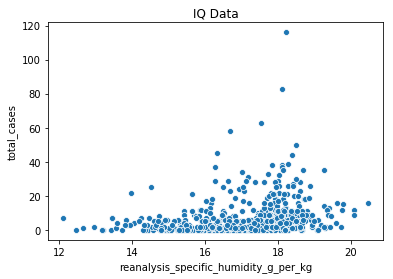

<Figure size 432x288 with 0 Axes>

In [32]:
sns.scatterplot(x="reanalysis_specific_humidity_g_per_kg", y="total_cases", data=sj_data).set_title("SJ Data")
plt.figure()
sns.scatterplot(x="reanalysis_specific_humidity_g_per_kg", y="total_cases", data=iq_data).set_title("IQ Data")
plt.figure()

### Dew point temperature vs total cases
- As with humidity, total cases also sees a spike in both cities when dew point temperature is within 294-298 kelvin. Once again this could indicate a relationship between the population size of dengue fever carrying mosqitoes and this temperature range. 

<Figure size 432x288 with 0 Axes>

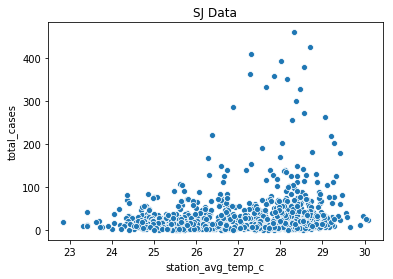

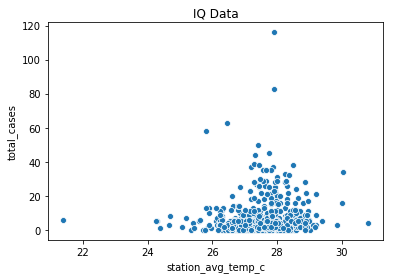

<Figure size 432x288 with 0 Axes>

In [99]:
sns.scatterplot(x="station_avg_temp_c", y="total_cases", data=sj_data).set_title("SJ Data")
plt.figure()
sns.scatterplot(x="station_avg_temp_c", y="total_cases", data=iq_data).set_title("IQ Data")
plt.figure()

## Humidity vs Total Cases
- Here we examine the relationship between grams of humidity per kg in both cities. As with air temp the number to cases of dengue fever begins to spike around the same humidity level of 16 for both cities.

<Figure size 432x288 with 0 Axes>

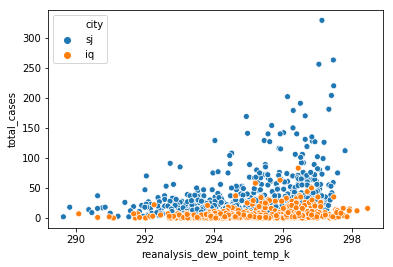

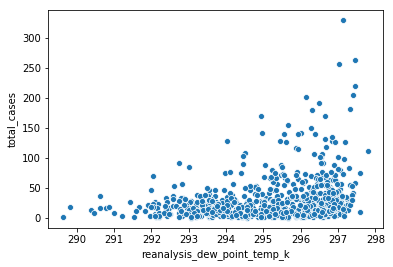

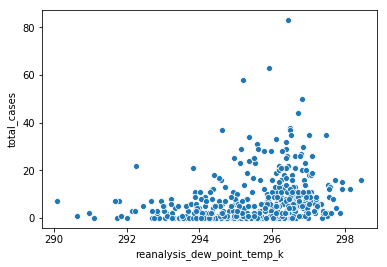

<Figure size 432x288 with 0 Axes>

In [128]:
sns.scatterplot(x="reanalysis_dew_point_temp_k", y="total_cases", hue="city", data=merged_data)
plt.figure()
sns.scatterplot(x="reanalysis_dew_point_temp_k", y="total_cases", data=sj_data)
plt.figure()
sns.scatterplot(x="reanalysis_dew_point_temp_k", y="total_cases", data=iq_data)
plt.figure()

## Reanalysis Dew Point

# Statistical Modeling

We are trying to predict the total number of cases of dengue fever in each city. Knowing this, the variable we are predicting total cases, is a non-negative integer, which indicates are looking to make count predictions. Based on this, we decided to analyze two possible statiscal models: poisson and negative binomial regression. Both of these models excel at making count predictions. The deciding factor for choosing between the two comes from looking at the mean and variance of the data set. A poisson regression assumes that the mean and variance are equal, if the variance is larger than the mean then we should use negative binomial regression.

In [51]:
print(sj_labels.mean())
print(sj_labels.var())

print(iq_labels.mean())
print(iq_labels.var())

total_cases    34.180556
dtype: float64
total_cases    2640.04544
dtype: float64
total_cases    7.565385
dtype: float64
total_cases    115.895524
dtype: float64


Looking at the mean and variance we can see that in both cities the variance is much higher than the mean. This means we will use a negative binomial regression. The variables chosen for the model are:
    - reanalysis_specific_humidity_g_per_kg
    - reanalysis_dew_point_temp_k
    - station_avg_temp_c
    - reanalysis_min_air_temp_k
    - station_min_temp_c 
These variables were chosen due to their high correlation to total_cases.

#### Forward Selection
First we define our method for method for forward selection. We use this to define our formula based on our selected variables for each city. This method was acquried from a blog mentioned in the slides: [planspace](https://planspace.org/20150423-forward_selection_with_statsmodels/)

In [38]:
def forward_selected(data, response):
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,' + '.join(selected))
    return formula

#### Format Data
- Next we define our function for formatting the data and preparing it to be fit to the model. This function first loads in the features data from the csv, then limits it to only the columns we have specified. It then handles all nan values with same forward fill used earlier. It then combines the labels data and finally seperates it by city.

In [57]:
def format_data(data_path, labels_path=None):
    # load data and set index to city, year, weekofyear
    df = pd.read_csv(data_path, index_col=[0, 1, 2])
    features = ["reanalysis_specific_humidity_g_per_kg", "reanalysis_dew_point_temp_k", "station_avg_temp_c", "reanalysis_min_air_temp_k", "station_min_temp_c"]
    df = df[features]
    df.fillna(method='ffill', inplace=True)

    labels = pd.read_csv(labels_path, index_col=[0, 1, 2])
    df = df.join(labels)
    
    # separate san juan and iquitos
    sj = df.loc['sj']
    iq = df.loc['iq']
    
    return sj, iq

In [58]:
#Load the city data
sj_data, iq_data = format_data('data/dengue_features_train.csv', labels_path="data/dengue_labels_train.csv")


In [85]:
# Use forward selection to get the formula that we will use to fit the model for SJ
formula = forward_selected(sj_data[["reanalysis_specific_humidity_g_per_kg", "reanalysis_dew_point_temp_k", "station_avg_temp_c", "reanalysis_min_air_temp_k", "station_min_temp_c", "total_cases"]], 'total_cases')

#Fit the SJ model
sj_model = smf.glm(formula=formula.model.formula, data=sj_data, family=sm.families.NegativeBinomial())
sj_model = sj_model.fit()

# Use forward selection to get the formula that we will use to fit the model for IQ
formula = forward_selected(iq_data[["reanalysis_specific_humidity_g_per_kg", "reanalysis_dew_point_temp_k", "station_avg_temp_c", "reanalysis_min_air_temp_k", "station_min_temp_c", "total_cases"]], 'total_cases')

#Fit the IQ model
iq_model = smf.glm(formula=formula.model.formula, data=iq_data, family=sm.families.NegativeBinomial())
iq_model = iq_model.fit()

In [92]:
sj_data["model_predictions"] = sj_model.predict()
iq_data["model_predictions"] = iq_model.predict()

## Interpretation

As we can see below the forward selection process includes reanalysis_specific_humidity_g_per_kg and reanalysis_dew_point_temp_k in the final formula to be used in the model for San Juan. The __reanalysis_specific_humidity_g_per_kg__ variable returned a coefficient of _1.1954_ meaning that for a every incrase in humidity_g_per_kg there is a _1.1954_ increase in total cases. Interestingly, __reanalysis_dew_point_temp_k__ returned a coefficient of _-0.9732_. This goes against intuition that warmer temperature means more mosqitoes, as this coefficient suggests that for every 1 kelvin increase in dew point temperature total cases of dengue goes down by _0.9732_. A possible explimination for this the temperate of the tropics and sub-tropics. Due to their location near the equator, they are likely warm for most of the year. This means that a drop in temperature could indicate an increasing in rain and standing water, while still remaining warm enough to be a stable environment for mosqitoes. 

In [93]:
sj_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            total_cases   No. Observations:                  936
Model:                            GLM   Df Residuals:                      933
Model Family:        NegativeBinomial   Df Model:                            2
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4203.2
Date:                Mon, 12 Nov 2018   Deviance:                       1000.5
Time:                        23:42:00   Pearson chi2:                 1.77e+03
No. Iterations:                     7   Covariance Type:             nonrobust
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                               270.8840    109.098      2.483      0.013      57.056     484.712
reanalysis_specific_humidity_g_per_kg     1.1954      0.394      3.034      0.002       0.423       1.968
reanalysis_dew_point_temp_k              -0.9732      0.392     -2.484      0.013      -1.741      -0.205
=========================================================================================================
"""

The forward selection for Iquitos chose __reanalysis_specific_humidity_g_per_kg__, __reanalysis_dew_point_temp_k__, and __station_min_temp_c__ to use in the formula for the model. Two of the variables __reanalysis_specific_humidity_g_per_kg__ and __reanalysis_dew_point_temp_k__ were also used in the formula for the above model. The coefficients of these variables tell a similiar story as the model above, but with even greater influence with __reanalysis_specific_humidity_g_per_kg__ having a coefficient of _1.8303_ and __reanalysis_dew_point_temp_k__ having a coefficient of _-1.6611_.

In [88]:
iq_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            total_cases   No. Observations:                  520
Model:                            GLM   Df Residuals:                      516
Model Family:        NegativeBinomial   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1564.9
Date:                Mon, 12 Nov 2018   Deviance:                       706.46
Time:                        23:37:58   Pearson chi2:                     802.
No. Iterations:                     7   Covariance Type:             nonrobust
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                               458.1881    140.858      3.253      0.001     182.112     734.264
reanalysis_specific_humidity_g_per_kg     1.8303      0.493      3.713      0.000       0.864       2.796
reanalysis_dew_point_temp_k              -1.6611      0.505     -3.287      0.001      -2.652      -0.671
station_min_temp_c                        0.1556      0.049      3.177      0.001       0.060       0.252
=========================================================================================================
"""

### Residual Plots
Looking at the residula plots we can see that our modals are most accurate when the number of total cases is low. The larger that number of cases are, the greater error has modals have at predicting the counts of deungue fever. This suggests that our models have issues predicting spikes in dengue cases. 

In [100]:
sns.scatterplot(sj_data.total_cases, sj_data.total_cases - sj_data.model_predictions, data=sj_data)
plt.axhline(0)
plt.figure()

sns.scatterplot(iq_data.total_cases, iq_data.total_cases - iq_data.model_predictions, data=iq_data)
plt.axhline(0)
plt.figure()

AttributeError: 'DataFrame' object has no attribute 'model_predictions'

<Figure size 432x288 with 0 Axes>

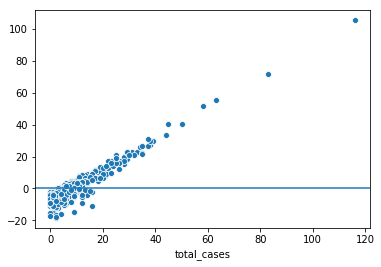

<Figure size 432x288 with 0 Axes>

In [95]:
sns.scatterplot(iq_data.total_cases, iq_data.total_cases - iq_data.model_predictions, data=iq_data)
plt.axhline(0)
plt.figure()

In [47]:
sj_test, iq_test = preprocess_data('data/dengue_features_test.csv')

sj_predictions = sj_best_model.predict(sj_test).astype(int)
iq_predictions = iq_best_model.predict(iq_test).astype(int)

submission = pd.read_csv("data/submission_format.csv",
                         index_col=[0, 1, 2])

submission.total_cases = np.concatenate([sj_predictions, iq_predictions])
submission.to_csv("data/submission.csv")